# PySpark Machine Learning Demo

## Overview of the Predictive Modeling Case

A financial services company offers a home equity line of credit to its clients. The
company has extended several thousand lines of credit in the past, and many of these
accepted applicants (approximately 20%) have defaulted on their loans. By using
geographic, demographic, and financial variables, the company wants to build a model
to predict whether an applicant will default.

## Data
After analyzing the data, the company selected a subset of 12 predictor (or input)
variables to model whether each applicant defaulted. The response (or target) variable
(BAD) indicates whether an applicant defaulted on the home equity line of credit.
These variables, along with their model role, measurement level, and description, are
shown in the following table from the <a href = "https://support.sas.com/documentation/onlinedoc/viya/examples.htm">**HMEQ**</a> data set.

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

## Loading packages

In [1]:
# Imports the connection information

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from operator import itemgetter
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.feature import Imputer, OneHotEncoder, StandardScaler, StringIndexer, UnivariateFeatureSelector, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession, DataFrame, Column
import pyspark.sql.functions as F
import time

## Initializing session

In [2]:
# Creates the Spark Session

spark = SparkSession.builder.appName("ml_comparison").getOrCreate()

## Loading data into memory

In [3]:
# Reads the CSV into memory

hmeq = spark.read.csv("hmeq.csv", header = True, inferSchema = True)

In [4]:
# Displays the type of the object

type(hmeq)

pyspark.sql.dataframe.DataFrame

In [5]:
# Displays a sample of the rows in the dataframe

hmeq.head(n = 5)

[Row(BAD=1, LOAN=1100, MORTDUE=25860.0, VALUE=39025.0, REASON='HomeImp', JOB='Other', YOJ=10.5, DEROG=0, DELINQ=0, CLAGE=94.3666666666667, NINQ=1, CLNO=9, DEBTINC=None),
 Row(BAD=1, LOAN=1300, MORTDUE=70053.0, VALUE=68400.0, REASON='HomeImp', JOB='Other', YOJ=7.0, DEROG=0, DELINQ=2, CLAGE=121.833333333333, NINQ=0, CLNO=14, DEBTINC=None),
 Row(BAD=1, LOAN=1500, MORTDUE=13500.0, VALUE=16700.0, REASON='HomeImp', JOB='Other', YOJ=4.0, DEROG=0, DELINQ=0, CLAGE=149.466666666667, NINQ=1, CLNO=10, DEBTINC=None),
 Row(BAD=1, LOAN=1500, MORTDUE=None, VALUE=None, REASON=None, JOB=None, YOJ=None, DEROG=None, DELINQ=None, CLAGE=None, NINQ=None, CLNO=None, DEBTINC=None),
 Row(BAD=0, LOAN=1700, MORTDUE=97800.0, VALUE=112000.0, REASON='HomeImp', JOB='Office', YOJ=3.0, DEROG=0, DELINQ=0, CLAGE=93.3333333333333, NINQ=0, CLNO=14, DEBTINC=None)]

In [6]:
# Displays the available columns in the dataset

print("Object type is", str(type(hmeq.columns)))
hmeq.columns

Object type is <class 'list'>


['BAD',
 'LOAN',
 'MORTDUE',
 'VALUE',
 'REASON',
 'JOB',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [7]:
# Display shape of the dataset

print("This table has", str(hmeq.count()), "rows and", str(len(hmeq.columns)), "columns")

This table has 5960 rows and 13 columns


## Data exploration

Explores the variable types, their distributions, missingness, and their correlations.

In [8]:
# Display a summary of the table

hmeq.printSchema()

root
 |-- BAD: integer (nullable = true)
 |-- LOAN: integer (nullable = true)
 |-- MORTDUE: double (nullable = true)
 |-- VALUE: double (nullable = true)
 |-- REASON: string (nullable = true)
 |-- JOB: string (nullable = true)
 |-- YOJ: double (nullable = true)
 |-- DEROG: integer (nullable = true)
 |-- DELINQ: integer (nullable = true)
 |-- CLAGE: double (nullable = true)
 |-- NINQ: integer (nullable = true)
 |-- CLNO: integer (nullable = true)
 |-- DEBTINC: double (nullable = true)



In [9]:
# Displays the column types

hmeq.dtypes

[('BAD', 'int'),
 ('LOAN', 'int'),
 ('MORTDUE', 'double'),
 ('VALUE', 'double'),
 ('REASON', 'string'),
 ('JOB', 'string'),
 ('YOJ', 'double'),
 ('DEROG', 'int'),
 ('DELINQ', 'int'),
 ('CLAGE', 'double'),
 ('NINQ', 'int'),
 ('CLNO', 'int'),
 ('DEBTINC', 'double')]

In [10]:
# Displaytype of target variable info

type(hmeq["BAD"])

pyspark.sql.column.Column

In [11]:
# Displays target variable distribution

target_dist = hmeq.groupby("BAD").count()
target_dist = target_dist.withColumn("percentage", F.round(target_dist["count"]*100/hmeq.count(), 3))
target_dist.show()

+---+-----+----------+
|BAD|count|percentage|
+---+-----+----------+
|  1| 1189|     19.95|
|  0| 4771|     80.05|
+---+-----+----------+



In [12]:
# Search for duplicate rows

hmeq.dropDuplicates().count()

5960

In [13]:
# Filters missing values

missing = {col: hmeq.filter(hmeq[col].isNull()).count() for col in hmeq.columns}

# Creates a dataframe

missing_df = pd.DataFrame.from_dict(missing, orient = "index", columns = ["nmiss_count"])
missing_df = missing_df.reset_index(names = ["column"])
missing_df["nmiss_pct"] = missing_df["nmiss_count"]*100/hmeq.count()

missing_df

,column,nmiss_count,nmiss_pct
0,BAD,0,0.000000
1,LOAN,0,0.000000
2,MORTDUE,518,8.691275
3,VALUE,112,1.879195
4,REASON,252,4.228188
5,JOB,279,4.681208
6,YOJ,515,8.640940
7,DEROG,708,11.879195
8,DELINQ,580,9.731544
9,CLAGE,308,5.167785


[Text(0, 0.0, '0%'),
 Text(0, 2.5, '2%'),
 Text(0, 5.0, '5%'),
 Text(0, 7.5, '8%'),
 Text(0, 10.0, '10%'),
 Text(0, 12.5, '12%'),
 Text(0, 15.0, '15%'),
 Text(0, 17.5, '18%'),
 Text(0, 20.0, '20%'),
 Text(0, 22.5, '22%')]

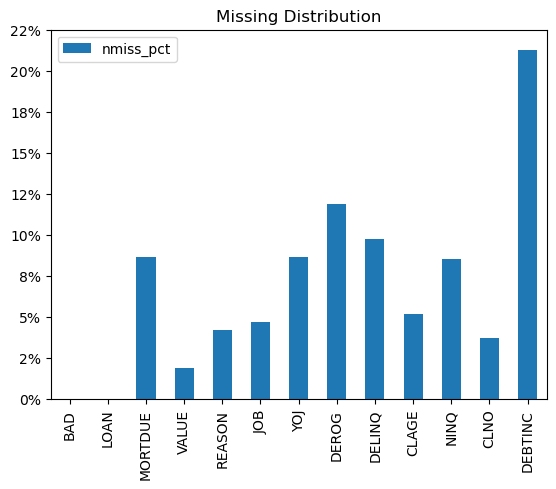

In [14]:
# Plots missing values

ax = missing_df.plot(x = "column", y = "nmiss_pct", xlabel = "", kind = "bar", title = "Missing Distribution")
y_vals = ax.get_yticks().tolist()
ax.set_yticks(y_vals)
ax.set_yticklabels(["{:.0f}%".format(i) for i in y_vals])

In [15]:
# Creates lists of the different variable types

ints = [i[0] for i in hmeq.dtypes if i[1] == "int"]
doubles = [i[0] for i in hmeq.dtypes if i[1] == "double"]
strings = [i[0] for i in hmeq.dtypes if i[1] == "string"]

In [16]:
# Display distribution of the different variable types

print("INTEGERS", end="\n")
hmeq.describe(ints + doubles).show()

INTEGERS
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|              BAD|              LOAN|             DEROG|            DELINQ|              NINQ|              CLNO|           MORTDUE|             VALUE|              YOJ|             CLAGE|           DEBTINC|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|             5960|              5960|              5252|              5380|              5450|              5738|              5442|              5848|             5445|              5652|              4693|
|   mean|0.199496644295302| 18607.96979865772|0.2545696877380046|0.4494423791821561|1.1860550458715597| 21.29609620076682| 

In [17]:
# Display distribution of the different variable types

print("INTEGERS", end="\n")
hmeq.describe(ints).show()

print("DOUBLES", end="\n")
hmeq.describe(doubles).show()

print("STRINGS", end="\n")
hmeq.describe(strings).show()

INTEGERS
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              BAD|              LOAN|             DEROG|            DELINQ|              NINQ|              CLNO|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|             5960|              5960|              5252|              5380|              5450|              5738|
|   mean|0.199496644295302| 18607.96979865772|0.2545696877380046|0.4494423791821561|1.1860550458715597| 21.29609620076682|
| stddev|0.399655517450269|11207.480416693992| 0.846046777086318|1.1272659176049744|1.7286749712080534|10.138933192458637|
|    min|                0|              1100|                 0|                 0|                 0|                 0|
|    max|                1|             89900|                10|                15|                17|                71|
+------

In [18]:
# Creates a pandas.DataFrame copy of HMEQ 

hmeq_df = hmeq.toPandas()

array([[<Axes: title={'center': 'BAD'}>,
        <Axes: title={'center': 'LOAN'}>,
        <Axes: title={'center': 'MORTDUE'}>],
       [<Axes: title={'center': 'VALUE'}>,
        <Axes: title={'center': 'YOJ'}>,
        <Axes: title={'center': 'DEROG'}>],
       [<Axes: title={'center': 'DELINQ'}>,
        <Axes: title={'center': 'CLAGE'}>,
        <Axes: title={'center': 'NINQ'}>],
       [<Axes: title={'center': 'CLNO'}>,
        <Axes: title={'center': 'DEBTINC'}>, <Axes: >]], dtype=object)

<Figure size 640x480 with 0 Axes>

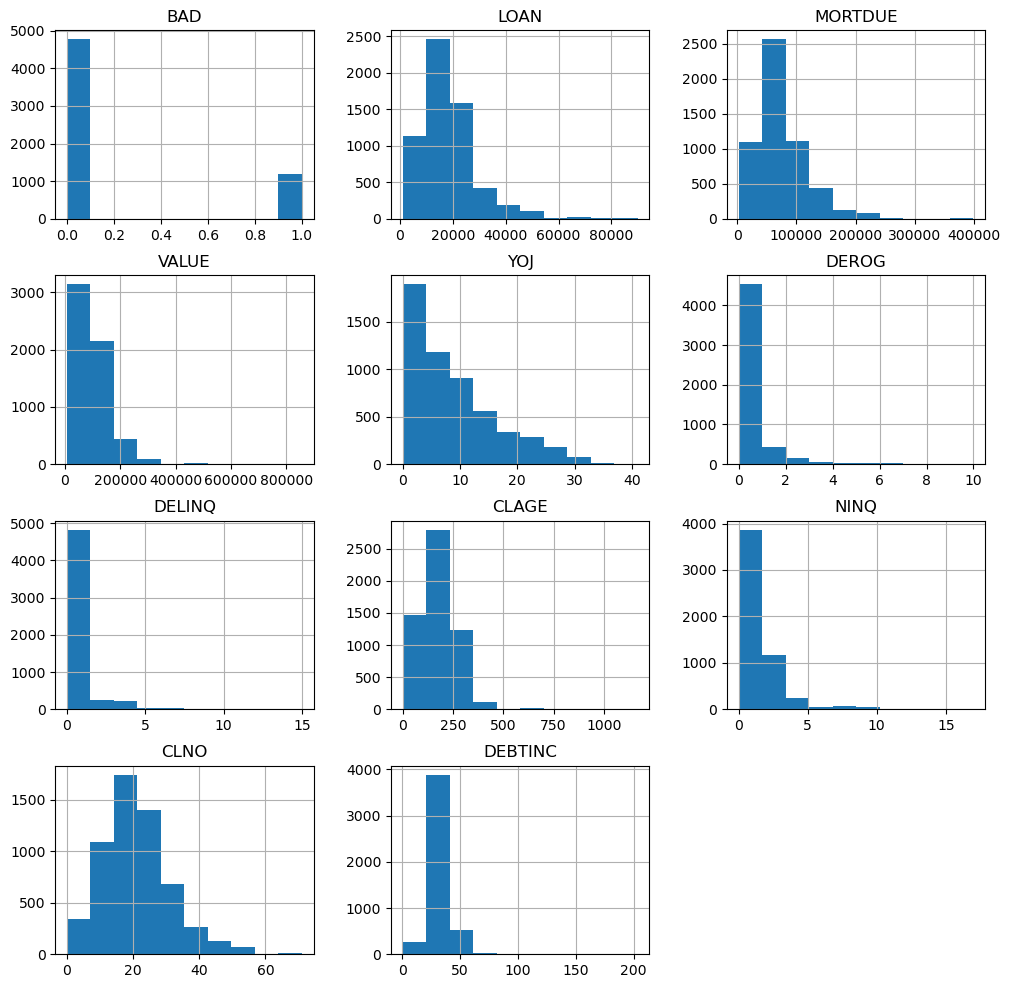

In [19]:
# Changes matplotlib parameters

plt.tight_layout()

# Plots histograms

hmeq_df.hist(figsize = (12,12))

In [20]:
# Creates a list of all non-string variables and no target variable

nums = ints[1:] + doubles

# Creates a list of the variables to be imputed by mode and mean

median = ["YOJ", "DEROG", "NINQ", "DELINQ"]
mean = [i for i in nums if i not in median]

In [21]:
# Displays the distribution of the string variables

print("REASON frequency table", end="\n")
reason_freq = hmeq.groupby("REASON").count().show()

print("JOB frequency table", end="\n")
job_freq = hmeq.groupby("JOB").count().show()

REASON frequency table
+-------+-----+
| REASON|count|
+-------+-----+
|HomeImp| 1780|
|   NULL|  252|
|DebtCon| 3928|
+-------+-----+

JOB frequency table
+-------+-----+
|    JOB|count|
+-------+-----+
|  Sales|  109|
| Office|  948|
|ProfExe| 1276|
|   NULL|  279|
|   Self|  193|
|  Other| 2388|
|    Mgr|  767|
+-------+-----+



In [22]:
# Prepares an assembler to vectorize the dataframe

assembler = VectorAssembler(inputCols = nums, outputCol = "features")

# Transforms the hmeq dataframe into vector form and removes rows that contain na from the analysis

vector_nums = assembler.transform(hmeq.dropna())
corr_matrix = Correlation.corr(vector_nums, "features").collect()

In [23]:
# Turns the correlation matrix into a numpy array

corr_arr = corr_matrix[0][0].toArray()
corr_df = pd.DataFrame(corr_arr, columns = nums, index = nums)

Text(0.5, 1.0, 'Correlation HeatMap')

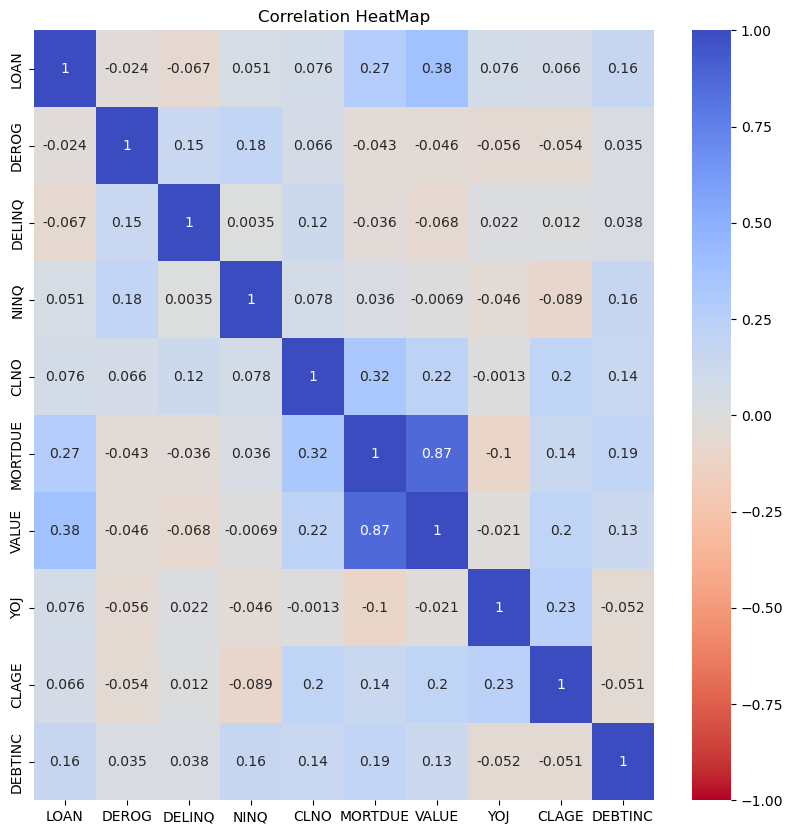

In [24]:
# Generates a heatmap using the correlation values

fig, ax = plt.subplots(figsize = (10,10))
cmap = plt.get_cmap("coolwarm").reversed()
corr_plot = sns.heatmap(corr_df, vmin = -1, vmax = 1, annot=True, cmap=cmap)
corr_plot.set_title("Correlation HeatMap")

### Ends the Spark Session. 

In [ ]:
# Ends the session

spark.stop()